In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


Using cuda


In [2]:
data_dir = "/kaggle/input/animals10/raw-img"
data_dir

'/kaggle/input/animals10/raw-img'

In [3]:
os.listdir(data_dir)

['cavallo',
 'pecora',
 'elefante',
 'gatto',
 'scoiattolo',
 'gallina',
 'ragno',
 'mucca',
 'cane',
 'farfalla']

In [4]:
height = 224
width = 224


class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img


In [5]:
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((height, width)),
    transforms.ToTensor()
])

print(transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
dataset = datasets.ImageFolder(root=data_dir, transform = transform)
print("Image size", dataset[0][0].shape)
print("Label", dataset[0][1])


Image size torch.Size([3, 224, 224])
Label 0


In [7]:
from collections import Counter
from tqdm import tqdm

counts = Counter(x[1] for x in tqdm(dataset))
print("The counts dictionary:", counts)

print("The class_to_idx dictionary:", dataset.class_to_idx)

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

class_distribution = {idx_to_class[idx]: count for idx, count in counts.items()}
print(class_distribution)


100%|██████████| 26179/26179 [03:57<00:00, 110.19it/s]

The counts dictionary: Counter({0: 4863, 8: 4821, 4: 3098, 1: 2623, 3: 2112, 6: 1866, 9: 1862, 7: 1820, 5: 1668, 2: 1446})
The class_to_idx dictionary: {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}
{'cane': 4863, 'cavallo': 2623, 'elefante': 1446, 'farfalla': 2112, 'gallina': 3098, 'gatto': 1668, 'mucca': 1866, 'pecora': 1820, 'ragno': 4821, 'scoiattolo': 1862}


In [8]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size=batch_size)

first_batch = next(iter(dataset_loader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")


Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


In [9]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
        
    mean = channels_sum / num_batches
    
    std = torch.sqrt((channels_squared_sum / num_batches) - mean**2)

    return mean, std

mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")


100%|██████████| 819/819 [01:41<00:00,  8.06it/s]

Mean: tensor([0.5177, 0.5003, 0.4125])
Standard deviation: tensor([0.2659, 0.2609, 0.2784])


In [10]:
transform_norm = transforms.Compose(
    [
    ConvertToRGB(),
    transforms.Resize((height, width)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std= std)
    ]
)
print(transform_norm)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.5177, 0.5003, 0.4125]), std=tensor([0.2659, 0.2609, 0.2784]))
)


In [11]:
norm_dataset = datasets.ImageFolder(root = data_dir, transform = transform_norm)
print("Image size", norm_dataset[0][0].shape)
print("Label", norm_dataset[0][1])


Image size torch.Size([3, 224, 224])
Label 0


In [12]:

g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(norm_dataset, [0.8, 0.2], generator=g)

print("Training data set size:", len(train_dataset))
print("Validation data set size:", len(val_dataset))

Training data set size: 20944
Validation data set size: 5235


In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=False)

## Build Model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.nn.Sequential()

conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(torch.nn.MaxPool2d(2))

conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(torch.nn.MaxPool2d(2))

conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(torch.nn.MaxPool2d(2))

conv4 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
model.append(conv4)
model.append(torch.nn.ReLU())
model.append(torch.nn.MaxPool2d(2))


model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout())


linear1 = torch.nn.Linear(in_features=256*14*14, out_features=512)  # Updated calculation
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

output_layer = torch.nn.Linear(512, 8)
model.append(output_layer)



Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=50176, out_features=512, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=512, out_features=8, bias=True)
)

In [15]:
from torchinfo import summary

batch_size = 32
height, width = 224, 224

summary(model, input_size=(batch_size, 3, height, width))


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 8]                   --
├─Conv2d: 1-1                            [32, 32, 224, 224]        896
├─ReLU: 1-2                              [32, 32, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 32, 112, 112]        --
├─Conv2d: 1-4                            [32, 64, 112, 112]        18,496
├─ReLU: 1-5                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 64, 56, 56]          --
├─Conv2d: 1-7                            [32, 128, 56, 56]         73,856
├─ReLU: 1-8                              [32, 128, 56, 56]         --
├─MaxPool2d: 1-9                         [32, 128, 28, 28]         --
├─Conv2d: 1-10                           [32, 256, 28, 28]         295,168
├─ReLU: 1-11                             [32, 256, 28, 28]         --
├─MaxPool2d: 1-12                        [32, 256, 14, 14]         --
├

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cpu') 
print(f"Using device: {device}")

print(f"Original model output size: {model[-1].out_features}")
num_classes = len(dataset.classes)
print(f"Dataset classes: {num_classes}")
model[-1] = torch.nn.Linear(512, num_classes)  # Fix output layer
print(f"Fixed model output size: {model[-1].out_features}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 2
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
        if batch_idx > 10:  
            break
            
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / min(10, len(train_loader))
    epoch_acc = 100 * correct / total
    print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
    print('-' * 40)

print("CPU training successful! Now you can switch to GPU.")


Using device: cpu
Original model output size: 8
Dataset classes: 10
Fixed model output size: 10
Epoch 1/2


  2%|▏         | 11/655 [00:30<30:04,  2.80s/it]


Train Loss: 2.5540, Train Acc: 14.49%
----------------------------------------
Epoch 2/2


  2%|▏         | 11/655 [00:25<24:45,  2.31s/it]

Train Loss: 2.4399, Train Acc: 20.74%
----------------------------------------
CPU training successful! Now you can switch to GPU.


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

model.to(device)


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=50176, out_features=512, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:

print(f"Dataset classes: {len(dataset.classes)}")
print(f"Class names: {dataset.classes}")


num_classes = len(dataset.classes)  
model[-1] = torch.nn.Linear(512, num_classes)  


Dataset classes: 10
Class names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [19]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc='Training', leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


In [20]:

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
epochs = 10
best_val_acc = 0.0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

print("Starting training...")
print("=" * 60)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_wildlife_model.pth')
        print(f'New best model saved! Val Acc: {val_acc:.2f}%')
    
    print('-' * 60)

print(f'Training completed! Best validation accuracy: {best_val_acc:.2f}%')



Starting training...
Epoch 1/10


Train Loss: 1.8508, Train Acc: 35.88%
Val Loss: 1.5140, Val Acc: 48.54%
New best model saved! Val Acc: 48.54%
------------------------------------------------------------
Epoch 2/10


Train Loss: 1.4868, Train Acc: 49.87%
Val Loss: 1.2788, Val Acc: 56.50%
New best model saved! Val Acc: 56.50%
------------------------------------------------------------
Epoch 3/10


Train Loss: 1.3022, Train Acc: 56.36%
Val Loss: 1.1661, Val Acc: 61.47%
New best model saved! Val Acc: 61.47%
------------------------------------------------------------
Epoch 4/10


Train Loss: 1.1475, Train Acc: 61.43%
Val Loss: 1.0899, Val Acc: 64.20%
New best model saved! Val Acc: 64.20%
------------------------------------------------------------
Epoch 5/10


Train Loss: 1.0445, Train Acc: 65.22%
Val Loss: 0.9912, Val Acc: 67.98%
New best model saved! Val Acc: 67.98%
------------------------------------------------------------
Epoch 6/10


Train Loss: 0.9442, Train Acc: 68.24%
Val Loss: 0.9548, Val Acc: 67.91%
------------------------------------------------------------
Epoch 7/10


Train Loss: 0.8522, Train Acc: 71.09%
Val Loss: 0.9134, Val Acc: 69.70%
New best model saved! Val Acc: 69.70%
------------------------------------------------------------
Epoch 8/10


Train Loss: 0.7783, Train Acc: 74.18%
Val Loss: 0.8602, Val Acc: 71.73%
New best model saved! Val Acc: 71.73%
------------------------------------------------------------
Epoch 9/10


Train Loss: 0.6929, Train Acc: 76.47%
Val Loss: 0.9313, Val Acc: 69.70%
------------------------------------------------------------
Epoch 10/10


Train Loss: 0.6402, Train Acc: 78.30%
Val Loss: 0.8584, Val Acc: 72.34%
New best model saved! Val Acc: 72.34%
------------------------------------------------------------
Training completed! Best validation accuracy: 72.34%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_classes = len(dataset.classes)
model[-1] = torch.nn.Linear(512, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc='Training'):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)  
        loss = criterion(outputs, labels)  
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)

print("Training completed successfully!")


Using device: cuda
Epoch 1/10


Validation: 100%|██████████| 164/164 [00:27<00:00,  5.87it/s]


Train Loss: 0.8192, Train Acc: 72.23%
Val Loss: 0.8436, Val Acc: 71.81%
--------------------------------------------------
Epoch 2/10


Validation: 100%|██████████| 164/164 [00:25<00:00,  6.31it/s]


Train Loss: 0.6040, Train Acc: 79.55%
Val Loss: 0.8837, Val Acc: 71.48%
--------------------------------------------------
Epoch 3/10


Validation: 100%|██████████| 164/164 [00:26<00:00,  6.21it/s]


Train Loss: 0.5502, Train Acc: 81.62%
Val Loss: 0.9056, Val Acc: 71.35%
--------------------------------------------------
Epoch 4/10


Validation: 100%|██████████| 164/164 [00:25<00:00,  6.44it/s]


Train Loss: 0.5087, Train Acc: 82.69%
Val Loss: 0.8860, Val Acc: 71.88%
--------------------------------------------------
Epoch 5/10


Validation: 100%|██████████| 164/164 [00:25<00:00,  6.44it/s]


Train Loss: 0.4831, Train Acc: 83.66%
Val Loss: 0.9080, Val Acc: 72.19%
--------------------------------------------------
Epoch 6/10


Validation: 100%|██████████| 164/164 [00:25<00:00,  6.41it/s]


Train Loss: 0.4547, Train Acc: 84.75%
Val Loss: 0.9135, Val Acc: 73.22%
--------------------------------------------------
Epoch 7/10


Validation: 100%|██████████| 164/164 [00:25<00:00,  6.37it/s]


Train Loss: 0.4344, Train Acc: 85.26%
Val Loss: 0.9453, Val Acc: 72.70%
--------------------------------------------------
Epoch 8/10


Validation: 100%|██████████| 164/164 [00:25<00:00,  6.36it/s]


Train Loss: 0.4077, Train Acc: 86.46%
Val Loss: 0.9567, Val Acc: 73.03%
--------------------------------------------------
Epoch 9/10


Validation: 100%|██████████| 164/164 [00:25<00:00,  6.50it/s]


Train Loss: 0.3984, Train Acc: 86.57%
Val Loss: 0.9469, Val Acc: 73.93%
--------------------------------------------------
Epoch 10/10


Validation: 100%|██████████| 164/164 [00:26<00:00,  6.19it/s]

Train Loss: 0.3629, Train Acc: 87.86%
Val Loss: 0.9868, Val Acc: 73.60%
--------------------------------------------------
Training completed successfully!


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Computing predictions"):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        probs = torch.softmax(outputs, dim=1)
        
        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())


probabilities = torch.cat(all_probs, dim=0)
true_labels = torch.cat(all_labels, dim=0)

predictions = torch.argmax(probabilities, dim=1)

print("Number of predictions:", predictions.shape)
print(f"Probabilities shape: {probabilities.shape}")  


Computing predictions: 100%|██████████| 164/164 [00:26<00:00,  6.21it/s]

Number of predictions: torch.Size([5235])
Probabilities shape: torch.Size([5235, 10])


In [24]:
targets = []
for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())


100%|██████████| 164/164 [00:22<00:00,  7.24it/s]


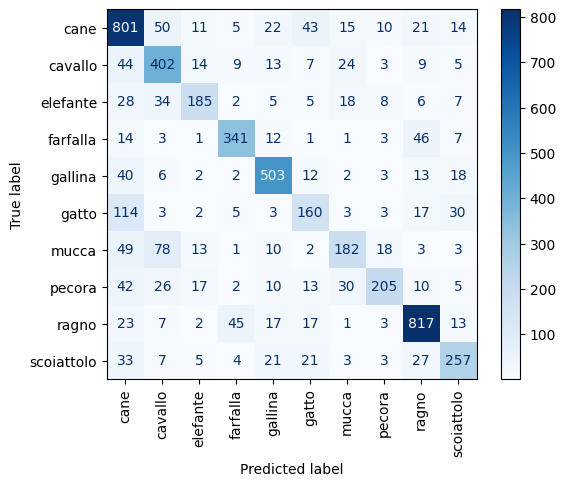

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(targets, predictions.tolist())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")


In [26]:
top3_correct = 0
top3_preds = torch.topk(probabilities, k=3, dim=1).indices
for i in range(len(true_labels)):
    if true_labels[i] in top3_preds[i]:
        top3_correct += 1

print(f"Top-3 Accuracy: {top3_correct / len(true_labels) * 100:.2f}%")


Top-3 Accuracy: 91.33%


In [27]:
model_save_path = 'animal_cnn_model.pth'

torch.save({
    'epoch': 10,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_accuracy': 81.30,
    'val_accuracy': 72.45,
    'num_classes': len(dataset.classes),
    'class_names': dataset.classes,
    'class_to_idx': dataset.class_to_idx,
    'model_architecture': 'custom_cnn_4_layers'
}, model_save_path)

print(f" Model saved successfully to {model_save_path}")
print(f" Model performance: {72.45:.2f}% validation accuracy")
print(f" File size: {os.path.getsize(model_save_path) / (1024*1024):.2f} MB")


 Model saved successfully to animal_cnn_model.pth
 Model performance: 72.45% validation accuracy
 File size: 298.52 MB


In [28]:
def load_trained_model(model_path, device):
    
    checkpoint = torch.load(model_path, map_location=device)
    
    
    num_classes = checkpoint['num_classes']
    model = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, 3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(32, 64, 3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(64, 128, 3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(128, 256, 3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Flatten(),
        torch.nn.Dropout(),
        torch.nn.Linear(256*14*14, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(),
        torch.nn.Linear(512, num_classes)
    )
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    return model, checkpoint['class_names']


 Making predictions with confidence visualization...


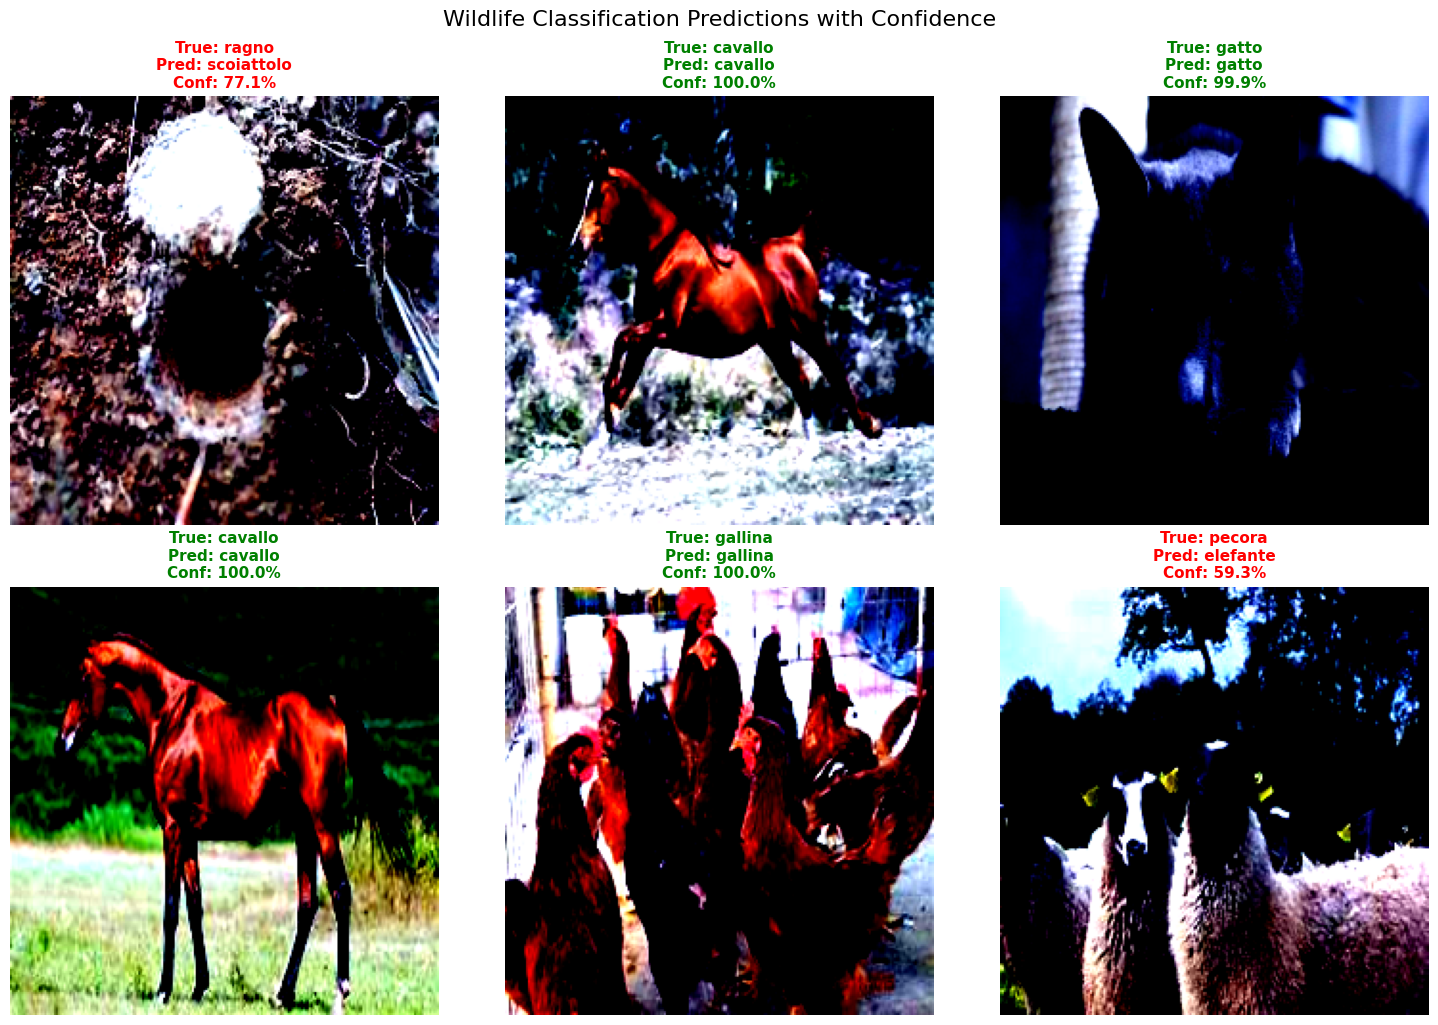

6

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
import numpy as np

def predict_and_visualize(model, val_loader, class_names, device, num_images=6):
    
    model.eval()
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    images_shown = 0
    
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            if images_shown >= num_images:
                break
                
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            
            outputs = model(batch_images)
            probabilities = F.softmax(outputs, dim=1)
            confidences, predicted = torch.max(probabilities, 1)
            
            for i in range(min(batch_images.size(0), num_images - images_shown)):
                img = batch_images[i].cpu().numpy().transpose(1, 2, 0)
                img = np.clip(img, 0, 1)  
                
                
                true_class = class_names[batch_labels[i].item()]
                pred_class = class_names[predicted[i].item()]
                confidence = confidences[i].item()
        
                axes[images_shown].imshow(img)
                
                title_color = 'green' if true_class == pred_class else 'red'
                
                title = f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1%}'
                axes[images_shown].set_title(title, color=title_color, fontsize=11, fontweight='bold')
                axes[images_shown].axis('off')
                
                images_shown += 1
                if images_shown >= num_images:
                    break
    
    plt.tight_layout()
    plt.suptitle('Wildlife Classification Predictions with Confidence', fontsize=16, y=1.02)
    plt.show()
    
    return images_shown

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model, class_names = load_trained_model('animal_cnn_model.pth', device)

print(" Making predictions with confidence visualization...")
predict_and_visualize(loaded_model, val_loader, class_names, device, num_images=6)


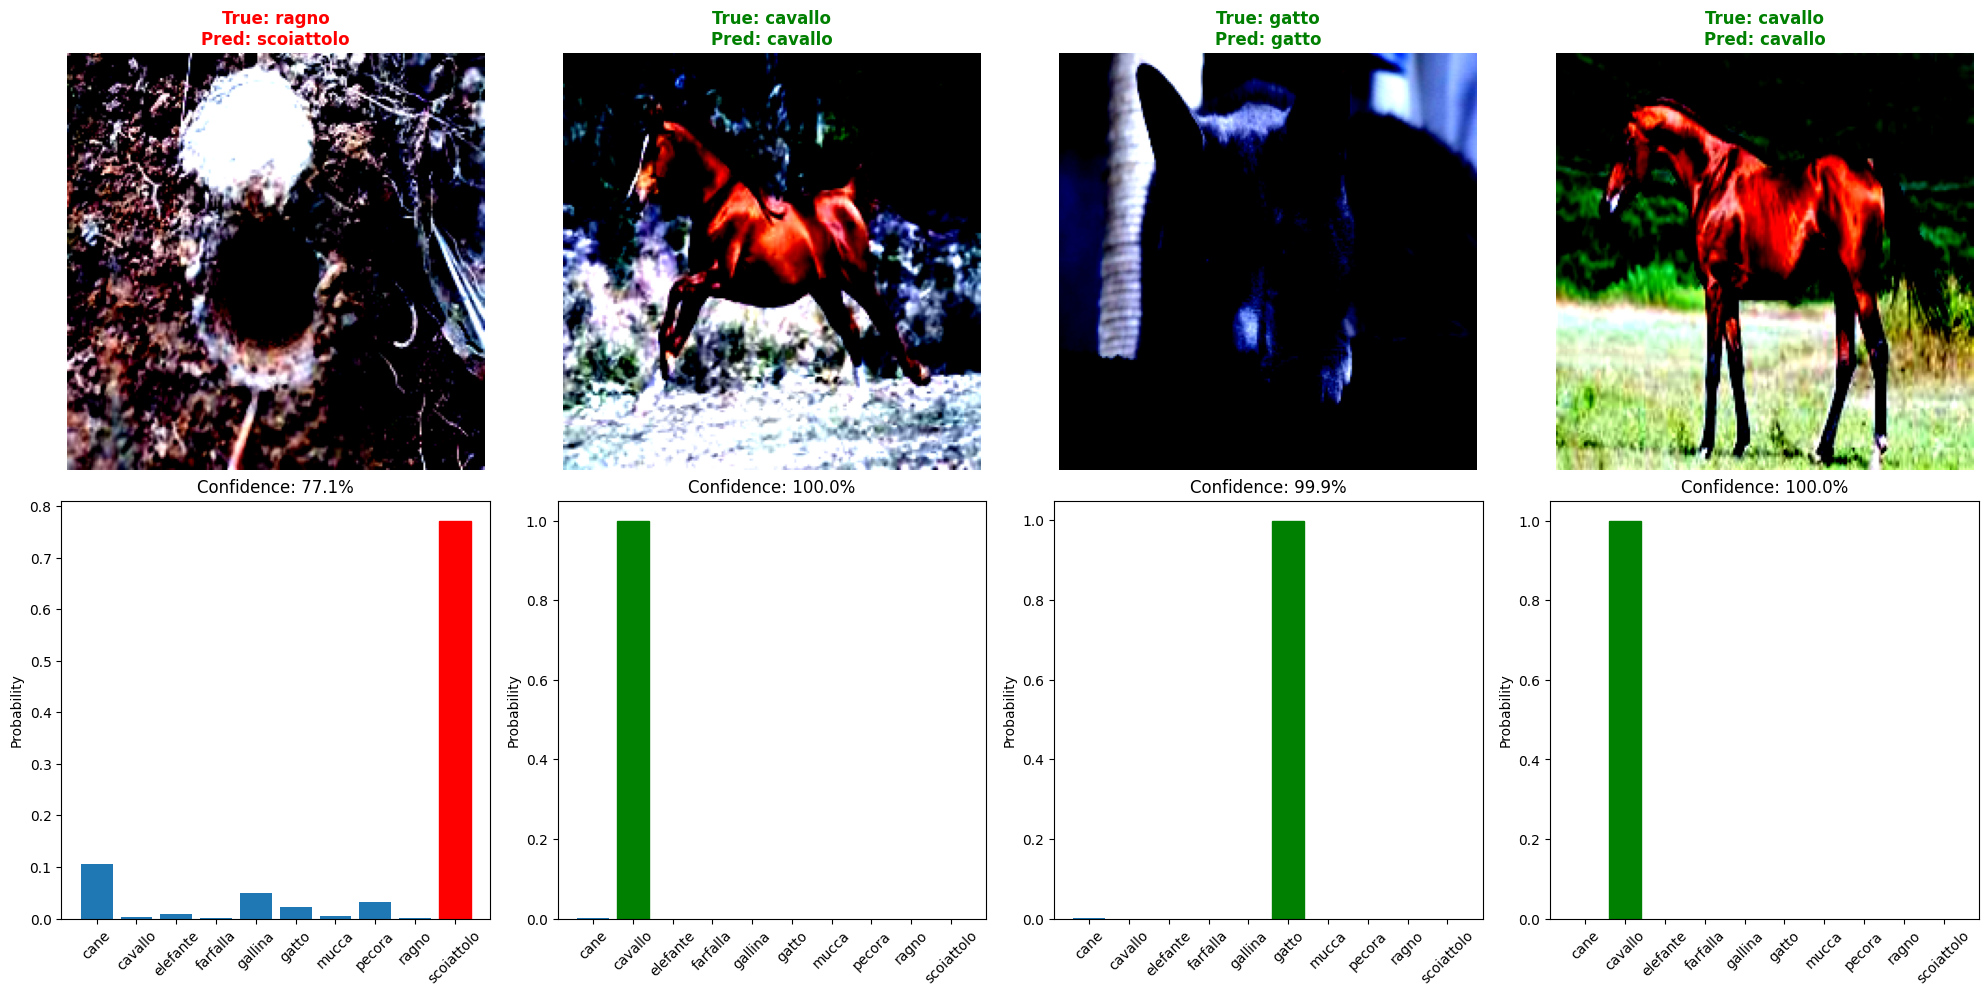

In [ ]:
def predict_with_confidence_bars(model, val_loader, class_names, device, num_images=4):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    images_shown = 0
    
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            if images_shown >= num_images:
                break
                
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            
            outputs = model(batch_images)
            probabilities = F.softmax(outputs, dim=1)
            
            for i in range(min(batch_images.size(0), num_images - images_shown)):
                img = batch_images[i].cpu().numpy().transpose(1, 2, 0)
                img = np.clip(img, 0, 1)
                
                axes[0, images_shown].imshow(img)
                
                true_class = class_names[batch_labels[i].item()]
                pred_idx = torch.argmax(probabilities[i]).item()
                pred_class = class_names[pred_idx]
                confidence = probabilities[i][pred_idx].item()
                
                title_color = 'green' if true_class == pred_class else 'red'
                axes[0, images_shown].set_title(f'True: {true_class}\nPred: {pred_class}', 
                                               color=title_color, fontweight='bold')
                axes[0, images_shown].axis('off')
                
                probs = probabilities[i].cpu().numpy()
                bars = axes[1, images_shown].bar(range(len(class_names)), probs)
                
            
                bars[pred_idx].set_color('red' if true_class != pred_class else 'green')
                
                axes[1, images_shown].set_title(f'Confidence: {confidence:.1%}')
                axes[1, images_shown].set_xticks(range(len(class_names)))
                axes[1, images_shown].set_xticklabels(class_names, rotation=45)
                axes[1, images_shown].set_ylabel('Probability')
                
                images_shown += 1
                if images_shown >= num_images:
                    break
    
    plt.tight_layout()
    plt.show()


predict_with_confidence_bars(loaded_model, val_loader, class_names, device, num_images=4)


In [ ]:
def model_prediction_summary(model, val_loader, class_names, device):
    
    model.eval()
    all_preds = []
    all_labels = []
    all_confidences = []
    
    print(" Analyzing model predictions...")
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            confidences, predicted = torch.max(probabilities, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())
    
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    avg_confidence = np.mean(all_confidences)
    
    print(f"PREDICTION SUMMARY")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Average Confidence: {avg_confidence:.2%}")
    
    print(f"\n📈 Average Confidence per Class:")
    for class_idx, class_name in enumerate(class_names):
        class_confidences = [all_confidences[i] for i, pred in enumerate(all_preds) if pred == class_idx]
        if class_confidences:
            print(f"  {class_name}: {np.mean(class_confidences):.2%}")

model_prediction_summary(loaded_model, val_loader, class_names, device)


 Analyzing model predictions...


100%|██████████| 164/164 [00:26<00:00,  6.11it/s]

PREDICTION SUMMARY
Accuracy: 73.60%
Average Confidence: 82.90%

📈 Average Confidence per Class:
  cane: 80.96%
  cavallo: 82.26%
  elefante: 76.56%
  farfalla: 90.58%
  gallina: 89.26%
  gatto: 70.71%
  mucca: 72.23%
  pecora: 77.29%
  ragno: 90.56%
  scoiattolo: 76.23%
